In [1]:
import os

import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
from nilearn import image, plotting
from nilearn.image import threshold_img
from templateflow import api as tflow

## Across subjects - 9 emotions

In [2]:
# Load all *_STAB.npy files in stab_folder
# data_root = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2"
data_root = "/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK2"  # sim01 folder

stab_mask_dir = os.path.join(data_root, "derivatives", "mvpa_08_stability_bold", "stab_full_masks")

STAB_files = [os.path.join(stab_mask_dir, f) for f in os.listdir(stab_mask_dir) if f.endswith("_STAB.npy") & f.startswith("sub-")]
STAB_files.sort()

n_subjects = len(STAB_files)
print(f"Found {n_subjects} subjects")

Found 20 subjects


In [3]:
example_func = nb.load(os.path.join(data_root, "derivatives/func_clean/sub-03_ses-01_task-02a_run-1_cleaned.nii.gz"))

In [4]:
# load all STAB files
STAB = np.zeros((97, 115, 97, n_subjects))
thres_stab = 0.1

for ii, f in enumerate(STAB_files):
    stab_mask_data = np.load(f)
    stab_mask_img = nb.Nifti1Image(stab_mask_data, example_func.affine, example_func.header)
    stab_mask_img_thres = image.threshold_img(stab_mask_img, threshold=thres_stab, two_sided=False)
    stab_mask_img_thres_bin = image.binarize_img(stab_mask_img_thres)

    STAB[..., ii] = stab_mask_img_thres_bin.get_fdata()

/tmp/ipykernel_3561828/3203561597.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  stab_mask_img_thres = image.threshold_img(stab_mask_img, threshold=thres_stab, two_sided=False)
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/image.py:1245: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img=threshold_img(


In [5]:
# compute the sum of stability masks
STAB_mean = np.sum(STAB, axis=3)

In [35]:
# estimate mean stability map
STAB_mean_img = nb.Nifti1Image(STAB_mean, example_func.affine, example_func.header)

# threshold the stability map
thres = 2
ct = 5
STAB_mean_img_thr = threshold_img(STAB_mean_img, threshold=thres, cluster_threshold=ct)

/tmp/ipykernel_3561828/848406183.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  STAB_mean_img_thr = threshold_img(STAB_mean_img, threshold=thres, cluster_threshold=ct)


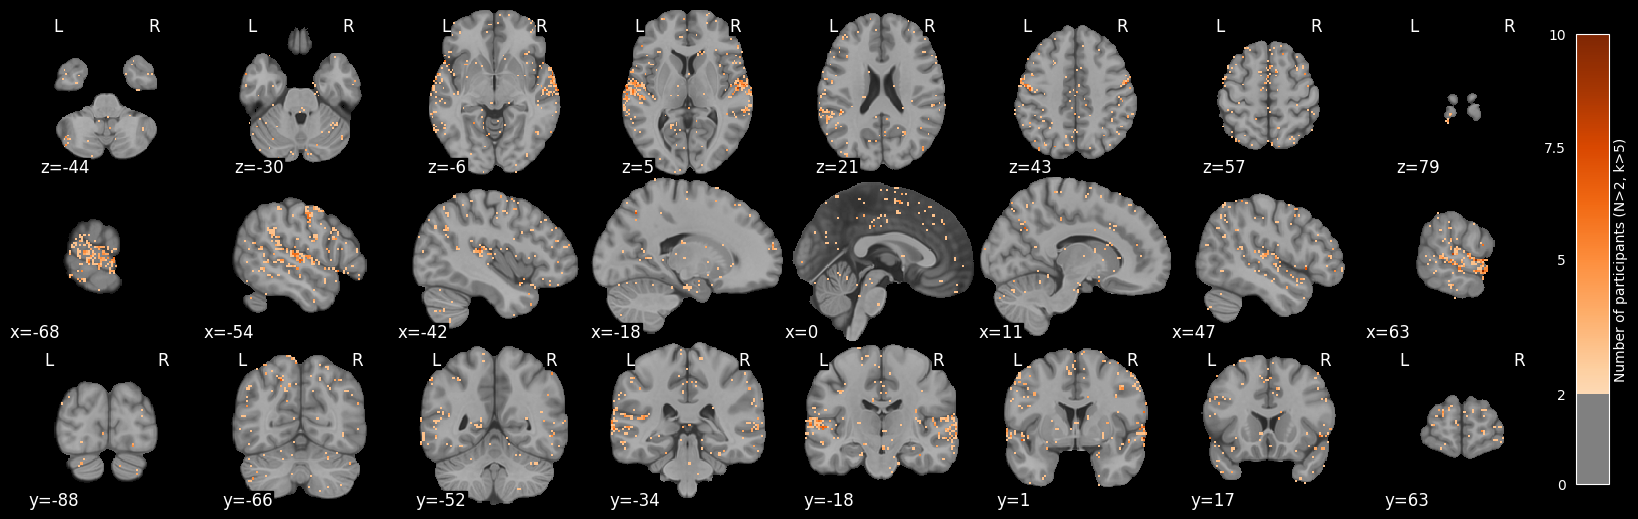

In [36]:
# beautiful mosaic figure

# Load the T1w image
t1w_img = tflow.get("MNI152NLin2009cAsym", desc="brain", resolution=1, suffix="T1w", extension="nii.gz")

# Create a new figure and axis with black background
fig = plt.figure(figsize=(16, 5), facecolor="black")

display = plotting.plot_stat_map(
    STAB_mean_img_thr,
    threshold=thres,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    symmetric_cbar=False,
    cmap="Oranges",
    figure=fig,
    bg_img=t1w_img,
    resampling_interpolation="nearest",
)

# Customize the colorbar
cbar = display._cbar
cbar.set_label(f"Number of participants (N>{thres}, k>{ct})")
# change colorbar label color to white
cbar.ax.yaxis.label.set_color("white")

# Show the plot
plt.show()

In [39]:
# get cluster table
# set pandas to display 100 rows
import pandas as pd
from mni_to_atlas import AtlasBrowser
from nilearn.reporting import get_clusters_table

pd.set_option("display.max_rows", 100)

atlas = AtlasBrowser("AAL3")

table, cluster_map = get_clusters_table(STAB_mean_img, thres, ct, return_label_maps=True, min_distance=15)

# AAL3 labelling
coordinates = table[["X", "Y", "Z"]].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)

# Add the labels to the table
table["AAL3"] = aal_labels

# print(table_g)
# print(table.to_latex())
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,63.5,1.5,-6.5,10.0,4384,Temporal_Sup_R
1,1a,57.5,-12.5,3.5,8.0,,Temporal_Sup_R
2,1b,63.5,-26.5,9.5,8.0,,Temporal_Sup_R
3,1c,55.5,-12.5,5.5,8.0,,Temporal_Sup_R
4,2,-42.5,-30.5,13.5,8.0,448,Rolandic_Oper_L
...,...,...,...,...,...,...,...
3357,3349,69.5,-16.5,-8.5,3.0,8,Temporal_Mid_R
3358,3350,-70.5,-42.5,-8.5,3.0,8,Temporal_Mid_L
3359,3351,-70.5,-44.5,1.5,3.0,24,Undefined
3360,3352,71.5,-24.5,-14.5,3.0,8,Temporal_Mid_R


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



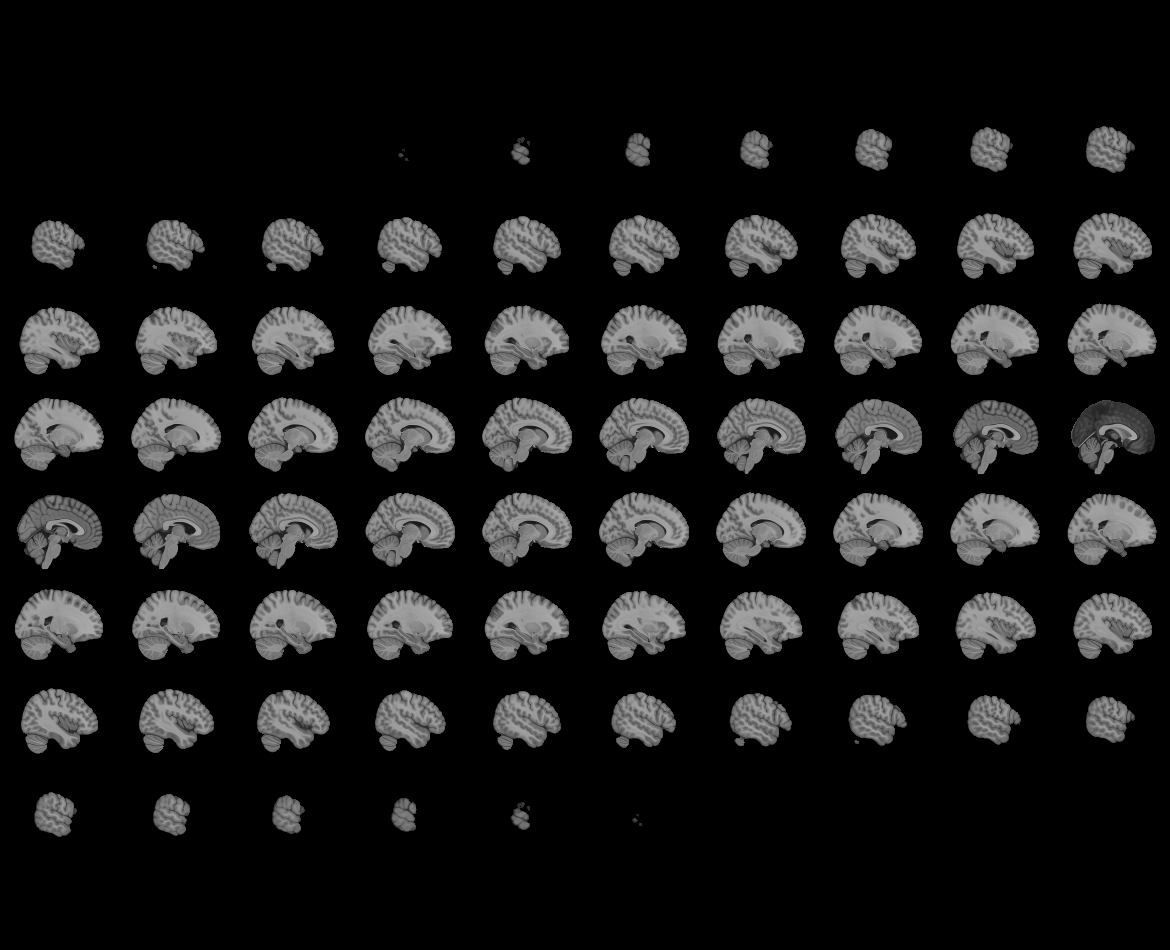
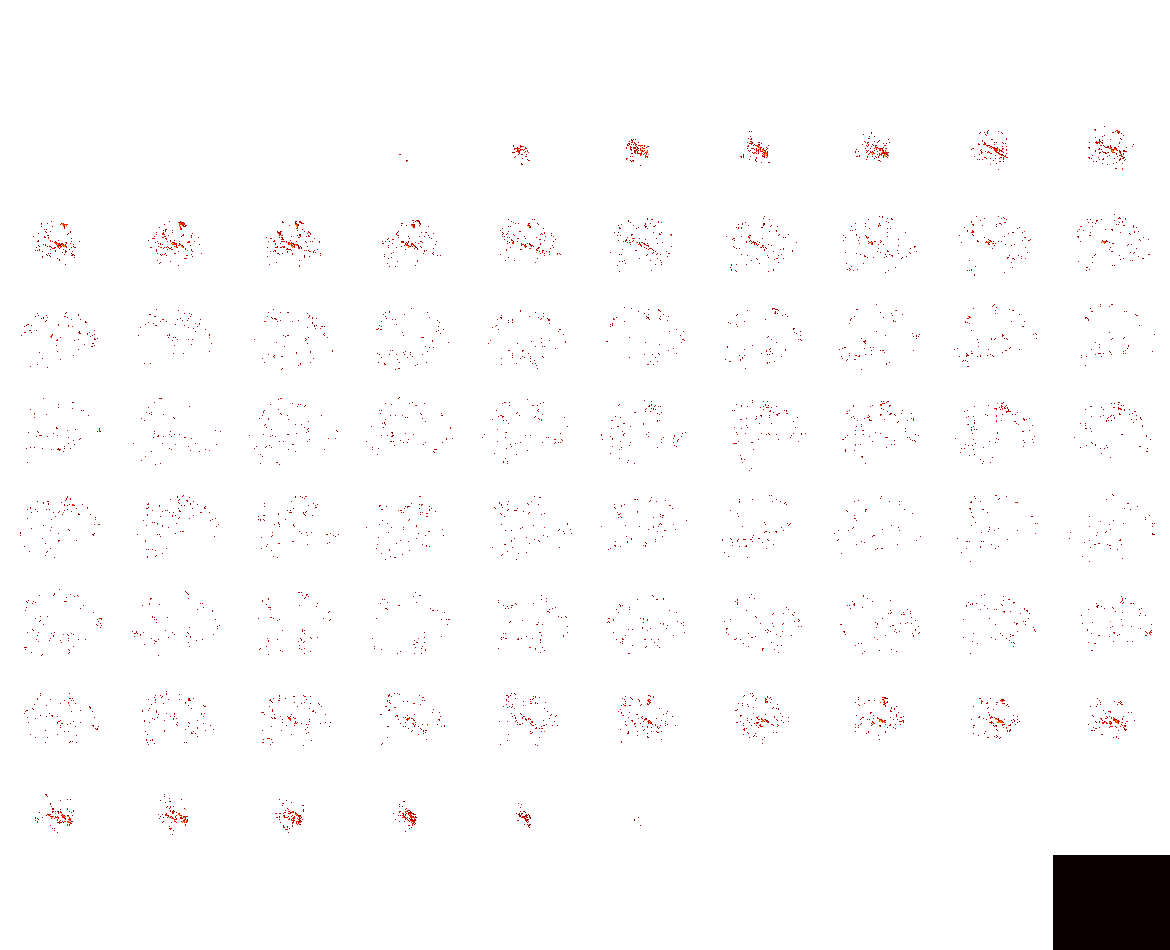

In [40]:
# plot STAB_mean_img_thr with view_img
plotting.view_img(STAB_mean_img_thr, title="STAB", colorbar=True, cmap="hot", width_view=1000, symmetric_cmap=False, threshold=thres)

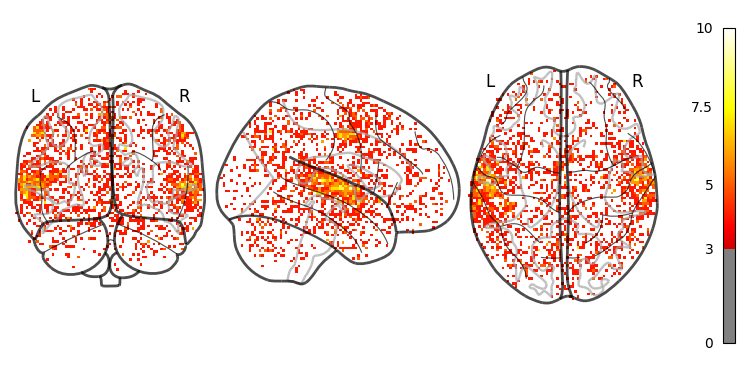

In [20]:
plotting.plot_glass_brain(STAB_mean_img_thr, colorbar=True, cmap="hot", threshold=thres)

# Single subject

In [ ]:
# Load sample image f'sub-{subject}_STAB.npy'
example_func = nb.load("/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/func_clean/sub-03_ses-01_task-02a_run-1_cleaned.nii.gz")
STAB_data = np.load("/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/mvpa_08_stability_bold/stab_full_masks/sub-03_STAB.npy")

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views


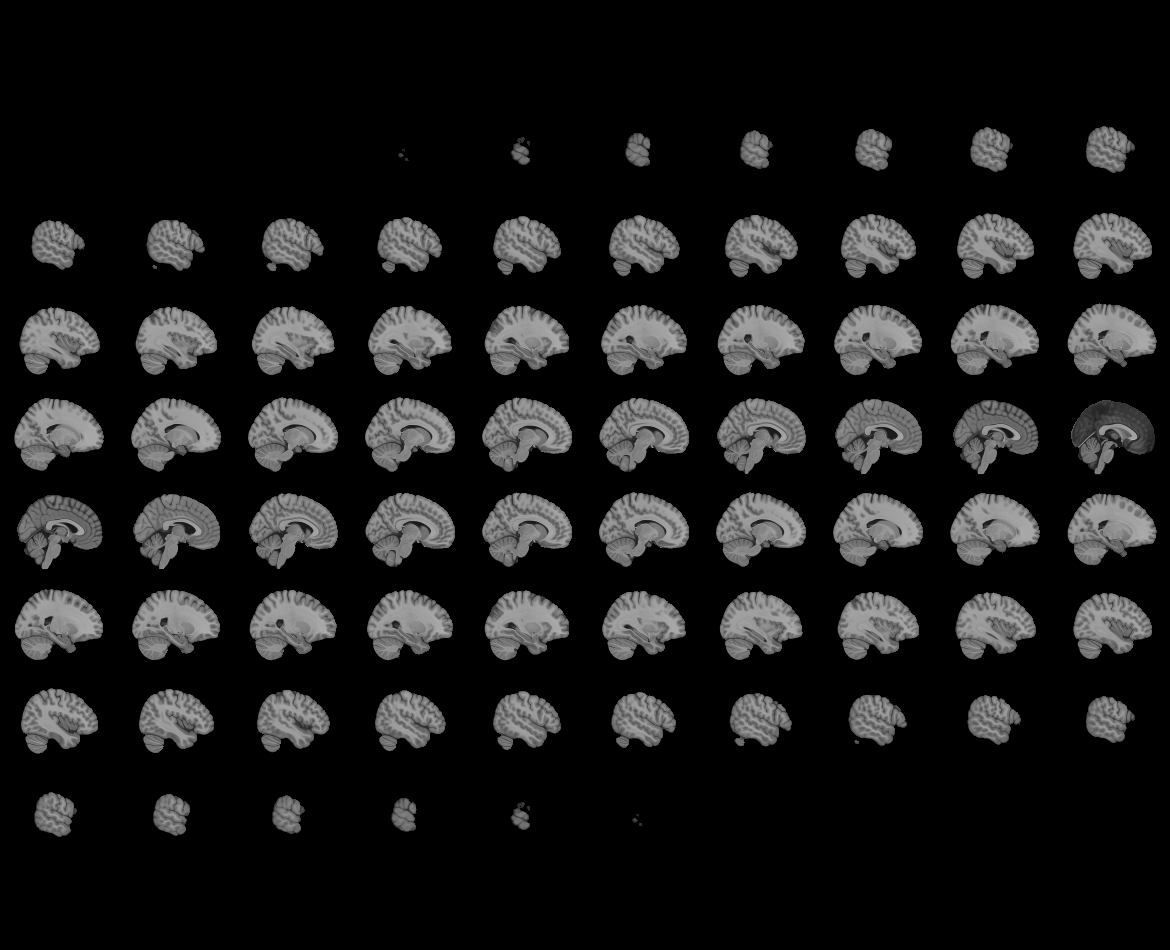
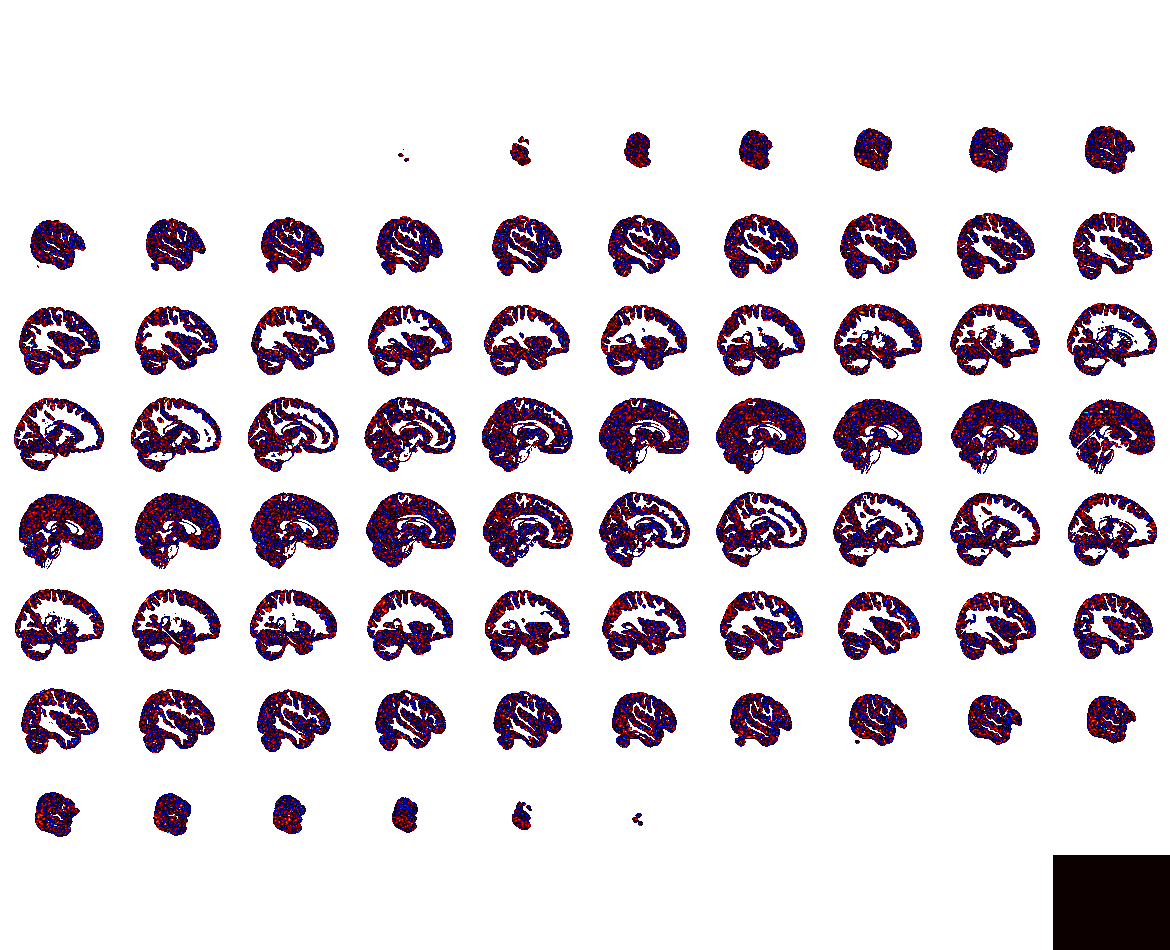

In [ ]:
plotting.view_img(example_func.slicer[..., 0])

In [43]:
STAB_data.shape

(97, 115, 97)

In [44]:
# mean stability map
STAB_mean_img = nb.Nifti1Image(STAB_data, example_func.affine, example_func.header)

# threshold the stability map
thres = 0.15
STAB_mean_img_thr = threshold_img(STAB_mean_img, threshold=thres)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/_utils/helpers.py:253: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  warnings.warn(


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/resampling.py:793: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0. 
Use 'force_resample=True' to suppress this warning.
  force_resample = _check_force_resample(force_resample)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views


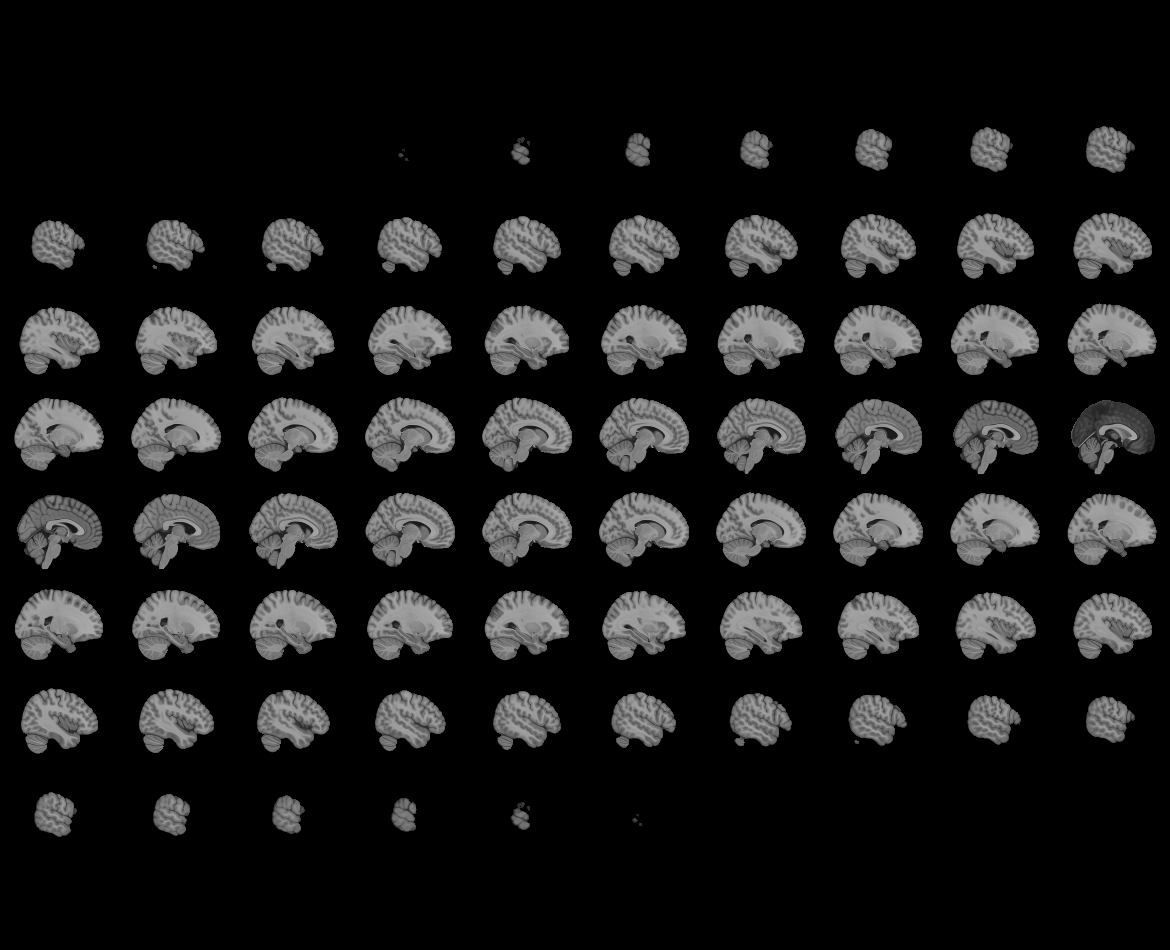
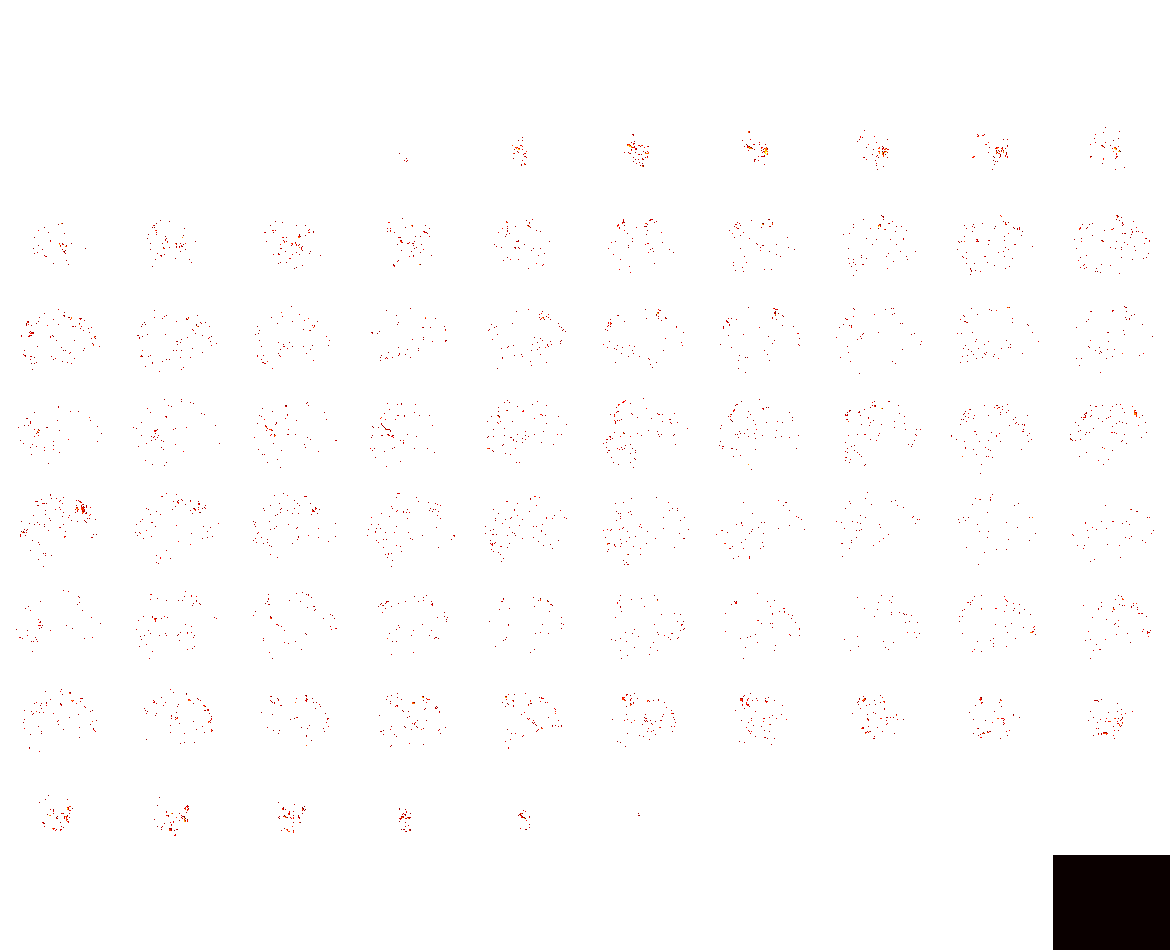

In [ ]:
# plot STAB_mean_img_thr with view_img
plotting.view_img(STAB_mean_img_thr, title="STAB", colorbar=True, cmap="hot", symmetric_cmap=False, threshold=thres)

In [ ]:
# count number of voxels > 0
print(np.sum(STAB_mean_img_thr.get_fdata() > 0))

4242
